## Hello, Nerds

I know that an oft-cited barrier to doing public hockey stats stuff is the inaccessibility of nice clean aggregated data, so I am sharing my R code in the hopes that it might help someone. Also, I probably won't publicly extend this analysis because of [REDACTED], but maybe you have ideas on how to extend it! The NHL Draft is very soon and all that jazz.

I would <i>highly</i> recommend scraping the data yourself in order to have the most updated information available as players sign new contracts this offseason. Nevertheless, [here is a .csv](https://github.com/namitanandakumar/Draft-Analysis/blob/master/Contracts/contracts.csv) of all the contract info I scraped for players drafted since 2005. It's current as of 5/23/2018.

In [1]:
import_library <- function(lib_name){
    suppressWarnings(suppressMessages(require(lib_name, character.only = TRUE)))
}

import_library('doParallel')
import_library('rvest')
import_library('dplyr')
import_library('lubridate')
import_library('bindrcpp')
import_library('readr')
import_library('ggplot2')
import_library('ggthemes')
import_library('LaCroixColoR')

no_cores <- detectCores() - 1
cl <- makeCluster(no_cores, outfile='')
registerDoParallel(cl)

Loading some packages. (I defined the import_library function to suppress the traditional package loading messages.) I have recently parallelized this code because it's "faster" and "why wasn't I doing that the whole time." Also, you might wonder if the LaCroixColoR package is optional, and I'm here to tell you that it's 100% [mandatory](https://github.com/johannesbjork/LaCroixColoR). Now, we can move on to messing with [CapFriendly](https://www.capfriendly.com/).

## Salary Data

In [2]:
drafted_players_cf <- function(year){
  draft <- read_html(paste('https://www.capfriendly.com/draft/', year, sep=''))
  players <- draft %>%
    html_nodes('td:nth-child(4) a') %>%
    html_attr("href") %>%
    paste('https://www.capfriendly.com', ., sep='')
  return(players)
}

This function will return a vector of all the player URLs from any draft year since 2005. It does appear that CapFriendly has less info about drafted prospects before 2010 or so who have never played any NHL games, so keep that in mind. (This is not their fault, their job is very difficult.)

In [3]:
drafted_players_cf(2015)[1:7]

[1] "https://www.capfriendly.com/players/connor-mcdavid" 
[2] "https://www.capfriendly.com/players/jack-eichel"    
[3] "https://www.capfriendly.com/players/dylan-strome"   
[4] "https://www.capfriendly.com/players/mitchell-marner"
[5] "https://www.capfriendly.com/players/noah-hanifin"   
[6] "https://www.capfriendly.com/players/pavel-zacha"    
[7] "https://www.capfriendly.com/players/ivan-provorov"

Here, for example, we see the best player drafted in 2015, and also the 6 players selected before him. Anyway, the real fun is coming up: scraping individual contract histories.

In [4]:
player_contracts_cf <- function(page){
  url <- read_html(page)
  name <- url %>%
    html_nodes('h1') %>%
    html_text() %>%
    gsub(' #.*','',.)
  contracts <- url %>%
    html_table(header = TRUE)
  label <- url %>%
    html_nodes('.cntrct h6') %>%
    html_text()
  team <- url %>%
    html_nodes('.mb2~ .mb2+ .mb2') %>%
    html_text() %>%
    gsub('SIGNING TEAM: ','',.)
  status <- url %>%
    html_nodes('.mb2:nth-child(5)') %>%
    html_text() %>%
    gsub('EXPIRY STATUS: ','',.)
  length <- url %>%
    html_nodes('.cb+ .mb2') %>%
    html_text() %>%
    gsub('LENGTH: ','',.) %>%
    gsub(' YEAR*.','',.)
  date <- url %>%
    html_nodes('.mb5:nth-child(3)') %>%
    html_text() %>%
    gsub('SIGNING DATE: ','',.) %>%
    mdy(.)
  overall <- url %>%
    html_nodes('.pld_c3:nth-child(2)') %>%
    html_text() %>%
    gsub('DRAFTED OVERALL: ','',.)
  year <- url %>%
    html_nodes('.pld_c3:nth-child(1)') %>%
    html_text() %>%
    gsub('DRAFT YEAR: ','',.)
  draftteam <- url %>%
    html_nodes('.pld_c3:nth-child(4)') %>%
    html_text() %>%
    gsub('DRAFTED BY: ','',.)
  contracts <- contracts[-length(contracts)]
  full <- c()
  if(length(label) > 0){
    for (i in 1:length(label)){
      temp <- data.frame(contracts[[i]],
                         TYPE = label[i],
                         SIGNINGTEAM = team[i],
                         EXPIRYSTATUS = status[i],
                         LENGTH = length[i],
                         SIGNED = date[i],
                         CONTRACTNUM = i)
      full <- rbind(full,temp)
    }
    full <- full %>%
      mutate(OVERALL = overall,
             DRAFTYEAR = year,
             DRAFTTEAM = draftteam,
             PLAYER = name,
             CLAUSE = replace(CLAUSE, CLAUSE=='', NA)) %>%
      arrange(SEASON, desc(SIGNED)) %>%
      mutate(CONTRACTNUM = match(CONTRACTNUM, unique(CONTRACTNUM)),
             TRIM = CONTRACTNUM - cummax(CONTRACTNUM)) %>%
      filter(TRIM == 0) %>%
      select(-TRIM) %>%
      rename_all(funs(gsub('[[:punct:]]', '', .))) %>%
      mutate_at(vars(OVERALL, LENGTH, CONTRACTNUM, DRAFTYEAR),
                funs(as.numeric(as.character(.)))) %>%
      mutate_at(vars(CAPHIT, AAV),
                funs(parse_number(.)))
  }
  print(paste(year, overall))
  return(full)
}

This was...a bit of an adventure. The gist is that I scrape all the tables of contract data on each player page, bind them together, add in the identifying information like name and draft pick/team, and then deal with stuff like buyouts (I exclude every year of a contract after it was bought out) and whatnot. But it works! And now, if you feed this function any player's CapFriendly page, it'll return a nice little contract history.

In [5]:
player_contracts_cf('https://www.capfriendly.com/players/sean-couturier')[,c(1:3,10:19)]
# Excluding the some salary/bonus-related columns from this output to make it easier to view.

[1] "2011 8"


SEASON,CLAUSE,CAPHIT,TYPE,SIGNINGTEAM,EXPIRYSTATUS,LENGTH,SIGNED,CONTRACTNUM,OVERALL,DRAFTYEAR,DRAFTTEAM,PLAYER
2011-12,NA,925000,ENTRY-LEVEL CONTRACT,Philadelphia Flyers,RFA,3,2011-09-26,1,8,2011,PHI,SEAN COUTURIER
2012-13,NA,925000,ENTRY-LEVEL CONTRACT,Philadelphia Flyers,RFA,3,2011-09-26,1,8,2011,PHI,SEAN COUTURIER
2013-14,NA,925000,ENTRY-LEVEL CONTRACT,Philadelphia Flyers,RFA,3,2011-09-26,1,8,2011,PHI,SEAN COUTURIER
2014-15,NA,1750000,STANDARD CONTRACT,Philadelphia Flyers,RFA,2,2013-07-20,2,8,2011,PHI,SEAN COUTURIER
2015-16,NA,1750000,STANDARD CONTRACT,Philadelphia Flyers,RFA,2,2013-07-20,2,8,2011,PHI,SEAN COUTURIER
2016-17,NA,4333333,STANDARD CONTRACT,Philadelphia Flyers,UFA,6,2015-07-28,3,8,2011,PHI,SEAN COUTURIER
2017-18,NA,4333333,STANDARD CONTRACT,Philadelphia Flyers,UFA,6,2015-07-28,3,8,2011,PHI,SEAN COUTURIER
2018-19,NA,4333333,STANDARD CONTRACT,Philadelphia Flyers,UFA,6,2015-07-28,3,8,2011,PHI,SEAN COUTURIER
2019-20,NA,4333333,STANDARD CONTRACT,Philadelphia Flyers,UFA,6,2015-07-28,3,8,2011,PHI,SEAN COUTURIER
2020-21,NA,4333333,STANDARD CONTRACT,Philadelphia Flyers,UFA,6,2015-07-28,3,8,2011,PHI,SEAN COUTURIER


(The function spits out draft year and pick number because that's how I keep track of progress when I run a long loop.) Okay, so the data we have includes season, no-trade/no-movement clauses, cap hit, signing team, free agent status after the expiry of the contract, signing date, draft information, etc. Draft year and pick number are very helpful for joining this data with other data, like NHL performance or something. Sometimes, you might think "I'll just join it by player name." and <i>that's how they get you</i>. Okay, now let's get all these URLs and get to work.

In [6]:
players <- foreach(year = 2005:2015,
                   .combine = c,
                   .packages='rvest') %dopar%
                    drafted_players_cf(year)

length(players)

[1] 1744

We have 1744 player pages to scrape, which is why this next loop takes a little while.

In [7]:
contracts <- foreach(k = 1:length(players),
                     .combine = rbind,
                     .packages= c('rvest','dplyr','lubridate','readr')) %dopar%
                      player_contracts_cf(players[k])

rownames(contracts) <- NULL
stopCluster(cl)

You can do anything with this contract data, but I decided to look back at an [old article I wrote](https://hockey-graphs.com/2017/03/28/exploiting-variance-in-the-nhl-draft/), where I initially used fake numbers to discuss how I think about evaluating NHL draft outcomes. The premise is that, among other things, we should be concerned with a player's second contract cap hit, a fairer assessment of value, and see if it's materially higher than the cap hit of that player's entry-level contract. We could look at that surplus value comprehensively with this data, but for now...

## Surplus NHL Draft Value: A <i>Very Quick</i> Look

In [8]:
second <- contracts %>%
  filter(CONTRACTNUM <= 2 & OVERALL <= 211) %>%
  group_by(DRAFTYEAR, PLAYER, CONTRACTNUM) %>%
  filter(CONTRACTNUM == 2 | TYPE == 'ENTRY-LEVEL CONTRACT') %>%
  filter(row_number() == 1) %>%
  group_by(DRAFTYEAR, PLAYER) %>%
  mutate(PREVIOUS = lag(CAPHIT)) %>%
  filter(!is.na(PREVIOUS)) %>%
  mutate(DIFF = CAPHIT - PREVIOUS) %>%
  ungroup()

For the sake of consistency, I took the top 211 picks in each year (goodbye, [Patric Hornqvist](http://66.media.tumblr.com/8ee28e276d15e628f9ec2604b0231044/tumblr_nyrhtrDQfq1retk6lo1_500.gif)), and then limited the data to players with a second contract, and <i>then</i> created columns for lagged cap hit and surplus value. The salary cap ceiling has certainly risen, and only a few players from 2015 have signed their second contract yet, so there are time-related adjustments that would have to be made for a deeper dive into this concept. But for now, we can do a lovely graph.

In [9]:
second <- second %>%
  mutate(DRAFTYEAR = replace(DRAFTYEAR, PLAYER == 'BRANDON BURLON', 2008),
         DRAFTYEAR = replace(DRAFTYEAR, PLAYER == 'ALLEN YORK', 2007))

(Actually, there are a couple of data errors to fix first. Let me know if you find more.)

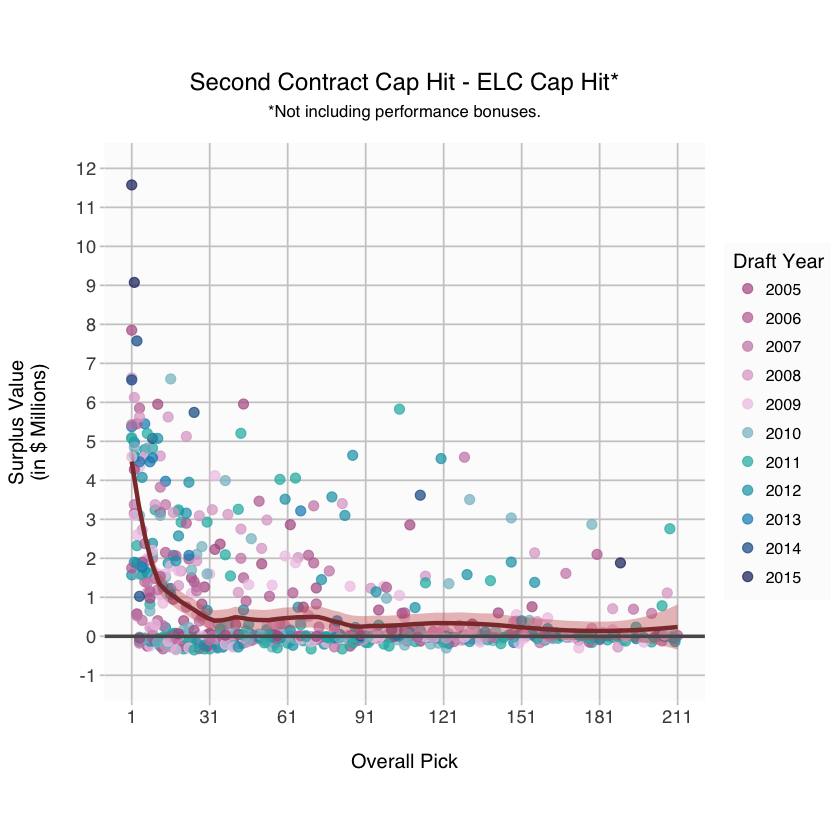

In [10]:
ggplot(second[sample(nrow(second)),],aes(OVERALL,DIFF/1000000)) +
  geom_point(aes(color=as.factor(DRAFTYEAR)),alpha=0.7,size=2.5) +
  geom_smooth(method='loess',col='indianred4',size=1.25,span=0.3,fill='indianred') +
  geom_hline(yintercept=0,col='gray35',size=1) +
  scale_y_continuous(limits=c(-1,12), breaks=seq(-1,12,1)) +
  scale_x_continuous(breaks=seq(1,300,30)) +
  scale_color_manual(values = lacroix_palette('Berry',n = 11,type = 'continuous')) +
  labs(x = '\nOverall Pick', y = 'Surplus Value\n(in $ Millions)\n',
       color = 'Draft Year', title = 'Second Contract Cap Hit - ELC Cap Hit*',
       subtitle = '*Not including performance bonuses.\n') +
  theme_hc() +
  theme(panel.grid.major.x = element_line(color='gray80'),
        panel.grid.major.y = element_line(color='gray80'),
        panel.background = element_rect(fill = 'gray99'),
        axis.text = element_text(size=11),
        legend.position = 'right',
        legend.background = element_rect(fill = 'gray99'),
        plot.title = element_text(hjust=0.5),
        plot.subtitle = element_text(hjust=0.5,size=10),
        axis.ticks = element_line(color='gray80')) + coord_fixed(ratio = 15)

The key here is that many players, especially in later rounds, would be classified as successes in traditional draft analyses using games played cutoffs. But even though they might be getting NHL playing time, are they creating value above and beyond what you can find in free agency? Again, feel free to read the article I linked above for more of the theoretical underpinning. It's also true that bridge contracts vs. long-term deals right out of the gate will affect the precise nature of this curve. Anyway, let me know if you find this helpful at all for any reason!